In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata

import pickle as pkl
from sklearn.preprocessing import minmax_scale

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h

#R interface
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

In [2]:
%%R
library('ComplexHeatmap')
library(viridis)
library(proxy)
library(seriation)
library(dendextend)

In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_markers='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [4]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [5]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

## Markers
Load markers from manually collected table.

In [6]:
# markers table
markers=pd.read_excel(path_markers+'markers.xlsx',sheet_name='beta_heterogeneity')

In [7]:
# orthologue mapping
orthologues=pd.read_table(path_markers+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename({'Gene name':'gs_mm','Human gene name':'gs_hs'},axis=1)

In [8]:
# Mouse markers
marker_names=set(markers.query('organism=="Mus musculus"')['gene_name'])
# Add human markers
marker_names_hs=set(markers.query('organism=="Homo sapiens"')['gene_name'])
marker_names=list(marker_names|set(orthologues.query('gs_hs in @marker_names_hs')['gs_mm']))
print("N marker genes:",len(marker_names))
print('Not in data:',[m for m in marker_names if m not in set(adata_rn_b.var.gene_symbol)])
marker_eids=list(set(adata_rn_b.var.query('gene_symbol in @marker_names').index))
print("N marker gene EIDs:",len(marker_eids))

N marker genes: 241
Not in data: []
N marker gene EIDs: 242


Expression strength of markers and filtering out markers expressed in only a few cells

In [9]:
# Calculate expression statistics
n_cells=pd.Series(np.array((adata_rn_b.X>0).sum(axis=0)).ravel(),
                     index=adata_rn_b.var_names)
mean_expr_in_exprc=pd.Series(
    np.array(adata_rn_b.X.sum(axis=0)).ravel()/n_cells.values.ravel(), 
                                index=adata_rn_b.var_names)
mean_expr_in_exprc.replace(np.nan,0,inplace=True)

<ipython-input-9-019ed55aa16b>:5: RuntimeWarning: invalid value encountered in true_divide
  np.array(adata_rn_b.X.sum(axis=0)).ravel()/n_cells.values.ravel(),


N cells == 0: ['Ddit3']


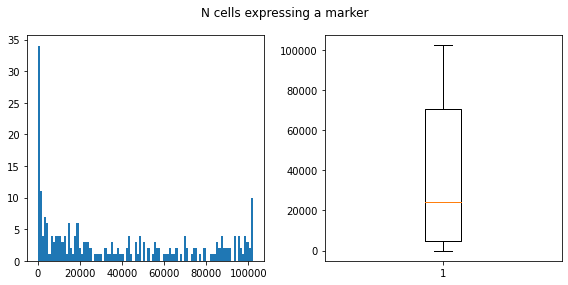

In [10]:
# Expression strength distn plots
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].hist(n_cells.loc[marker_eids].values,bins=100)
fig.suptitle('N cells expressing a marker')
ax[1].boxplot(n_cells.loc[marker_eids].values)
fig.tight_layout()
print('N cells == 0:',adata_rn_b.var.loc[
    n_cells.loc[marker_eids].index[n_cells.loc[marker_eids]==0],'gene_symbol'].tolist())

Text(0.5, 0, 'Mean expression in expressing cells for markers')

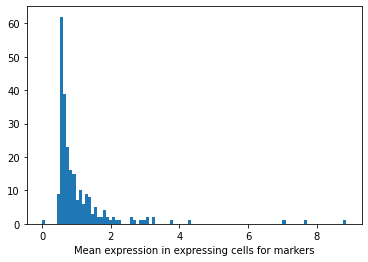

In [11]:
a=plt.hist(mean_expr_in_exprc.loc[marker_eids].values,bins=100)
plt.xlabel('Mean expression in expressing cells for markers')

In [10]:
# Remove markers expressed in little cells
unexpressed_eids=n_cells.loc[marker_eids].index[
    n_cells.loc[marker_eids]<adata_rn_b.shape[0]*0.01].tolist()
marker_eids=list(set([g for g in marker_eids if g not in unexpressed_eids]))
marker_names=list(set([g for g in adata_rn_b.var.loc[marker_eids,'gene_symbol'] 
                       if g in marker_names]))
print('Remaining N names and EIDs:',len(marker_names),len(marker_eids))

Remaining N names and EIDs: 208 208


## Marker expression

In [11]:
# Genes to be marked on the heatmap
genes_show=['Slc2a2', 'Ucn3', 'Mafa', 'Sytl4',
            'Nkx6-1', 'Chga', 'Nkx2-2', 'Pdx1',
            'Ins1','Ins2',
            'Gc', 'Cd81', 'Cck','Serpine1',
            'Chgb','Iapp','Neurog3',
            'Ccl4', 'Cxcl10', 'Cxcl1','Rbp4', 'Mafb',
            'Gpx3', 'Cdkn1a', 'Cdkn2b',  'Cdkn2a', 'Atf3',
           'Glp1r','Tnfrsf11b','Abcc8','Cat','Npy']
ro.globalenv['genes_show']=genes_show

In [12]:
# Cell clusters
cell_clustering='hc_gene_programs_parsed'
ro.globalenv['cell_cls']=[str(cl) for cl in adata_rn_b.obs[cell_clustering].unique().tolist()]
ro.globalenv['cell_cls_order']=[str(cl) for cl in 
                                adata_rn_b.obs[cell_clustering].cat.categories.tolist()]
# Cell cl colors
# Map python named colors to HEX
BASE_COLORS_hex = {name:mcolors.rgb2hex(color) for name,color in mcolors.BASE_COLORS.items()}
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)
all_named_colors.update(BASE_COLORS_hex)
all_named_colors.update(mcolors.CSS4_COLORS)
all_named_colors.update(mcolors.XKCD_COLORS)
# Extract cl colors
ro.globalenv['cell_cls_colors']=[all_named_colors[c] 
                                 for c in adata_rn_b.uns[cell_clustering+'_colors'][
                                     :adata_rn_b.obs[cell_clustering].nunique()]]

In [14]:
# Gene annotation
marker_anno=pd.DataFrame(index=marker_names)
for subtype,data in markers.query('gene_name in @marker_names').groupby('subtype'):
    marker_anno.loc[data['gene_name'].unique(),subtype]=1
marker_anno.fillna(0,inplace=True)
marker_anno=marker_anno.astype(bool) 
ro.globalenv['marker_anno']=marker_anno

In [34]:
# Make df of genes vs mean expression across cell clusters 
cl_col='hc_gene_programs_parsed'
genes=marker_eids
cell_cls=adata_rn_b.obs[cl_col].unique()
# Remove clusters with lowQ cells
cell_cls=[c for c in cell_cls if 'lowQ' not in c]
data_genes_pb=pd.DataFrame(index=genes,columns=cell_cls)
for cell_cl in cell_cls:
    data_genes_pb[cell_cl]=np.array(adata_rn_b[
        adata_rn_b.obs[cl_col]==cell_cl,features.index].X.mean(axis=0)).ravel()

In [35]:
# Normalised expression df
data_genes_pb=data_genes_pb.T
data_genes_pb.columns=adata_rn_b.var.loc[data_genes_pb.columns,'gene_symbol']
data_genes_pb=pd.DataFrame(minmax_scale(data_genes_pb),
                       index=data_genes_pb.index,columns=data_genes_pb.columns)
ro.globalenv['data_genes_pb']=data_genes_pb

In [37]:
%%R -o genes_order_pb
# Order genes
distances<-dist(t(data_genes_pb), method="Euclidean")
hc<-hclust(d=distances, method = "ward.D2" )
hc_ordered<-reorder(x=hc,dist = distances)
genes_order_pb<- as.dendrogram(hc_ordered) %>% labels

In [38]:
%%R
# Marker annotation
# Order marker anno
marker_anno_ordered<-marker_anno[genes_order_pb,]
marker_anno_colnames<-colnames(marker_anno_ordered)
marker_anno_ordered<-as.matrix(marker_anno_ordered)
colnames(marker_anno_ordered)<-marker_anno_colnames

In [39]:
%%R -o cells_order_pb
# Order cells
distances<-dist(data_genes_pb, method="Euclidean")
hc<-hclust(d=distances, method = "ward.D2" )
hc_ordered<-reorder(x=hc,dist = distances)
cells_order_pb<- as.dendrogram(hc_ordered) %>% labels

In [40]:
%%R
# Cell annotation
cell_cls<-factor(cells_order_pb, levels = cell_cls_order)
cell_cls_colors<-unlist(cell_cls_colors)
cell_cl_colormap<-cell_cls_colors
names(cell_cl_colormap)<-cell_cls_order
ha_col=rowAnnotation(
    'cell_clusters' = cell_cls,
    col = list(cell_clusters = cell_cl_colormap),
    show_annotation_name = c(cell_clusters = FALSE),
    show_legend=FALSE
)

In [41]:
# Select genes for annotating and determine index for marking
genes_show_idx_pb=[np.argwhere(genes_order_pb==g)[0][0] for g in genes_show]
ro.globalenv['genes_show_idx_pb']=genes_show_idx_pb

In [44]:
%%R
# Gene info annotation - names and marking subtype
genes_show<-unlist(genes_show)
genes_show_idx_pb<-unlist(genes_show_idx_pb)
ha_row = columnAnnotation(
    genes=anno_mark(at = genes_show_idx_pb, labels = genes_show),
    marker=marker_anno_ordered,
    col = list(marker = setNames( c("#dedede", "violetred4"),c(FALSE,TRUE))),
    annotation_name_side = "left"
)

Plot, but not save

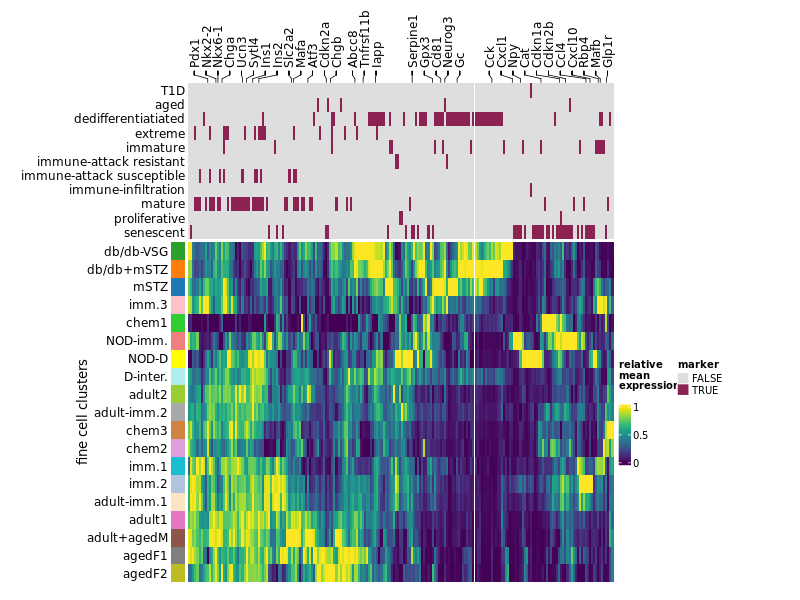

In [45]:
%%R -w 800 -h 600 
h<-Heatmap(data_genes_pb[cells_order_pb,genes_order_pb],col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = FALSE, show_row_names = TRUE,
       row_title ="fine cell clusters",
       top_annotation=ha_row,
       left_annotation=ha_col,row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nmean\nexpression\n"),
       row_gap = unit(0, "mm"),
       width= unit(15, "cm"), height= unit(12, "cm"),
       show_row_dend = FALSE, 
       )
draw(h)

Save plot

In [47]:
%%R
pdf(file=paste0(path_fig,"heatmap_beta_knownmarkers_CLfine.pdf"), width=9.7, height=8)
h<-Heatmap(data_genes_pb[cells_order_pb,genes_order_pb],col=viridis(256),
       cluster_columns = FALSE, cluster_rows = FALSE,
       show_column_names = FALSE, show_row_names = TRUE,
       row_title ="Cell clusters",
       top_annotation=ha_row,
       left_annotation=ha_col,row_names_side = "left",
       heatmap_legend_param = list( title = "relative\nmean\nexpression\n"),
       row_gap = unit(0, "mm"),
       width= unit(15, "cm"), height= unit(12, "cm"),
       show_row_dend = FALSE,
       )
draw(h)
dev.off()

[1] 2


## Marker state overlaps
Look into markers previously reported for multiple states

In [42]:
# Size of marker group overlaps
categories_count=pd.DataFrame(marker_anno.groupby(list(marker_anno.columns)).\
                              size().rename('count').reset_index())
# N beta cell states in each marker group
categories_count['n_states']=(categories_count.drop('count',axis=1)==True).sum(axis=1)

In [46]:
# report genes that have multiple annotations nd these annotations;
# group genes by states they are annotated with
for idx,data in categories_count.iterrows():
    if data['n_states']>1:
        states=[state for state in data.index if data[state]==True and state!='count']
        print(states,
              'N genes',data['count'])
        genes=set(marker_anno.index)
        for state in states:
            genes=genes&set(marker_anno[marker_anno[state]].index)
        print(genes)

['proliferative', 'senescent'] N genes 1
{'Cdkn1a'}
['immune-attack susceptible', 'mature'] N genes 5
{'Ins2', 'Slc2a2', 'Ins1', 'Pdx1', 'Mafa', 'Foxo1', 'Slc30a8', 'Nkx6-1', 'G6pc2'}
['immature', 'senescent'] N genes 1
{'Ldha'}
['extreme', 'mature'] N genes 4
{'Pcsk1', 'Kcnj11', 'Ins2', 'Slc2a2', 'Ins1', 'Pdx1', 'Pcsk2', 'Ero1b', 'Ucn3'}
['extreme', 'immune-attack susceptible', 'mature'] N genes 4
{'Pdx1', 'Ins2', 'Slc2a2', 'Ins1'}
['extreme', 'immature', 'immune-attack susceptible'] N genes 1
{'Chga'}
['dedifferentiatiated', 'immune-attack resistant'] N genes 1
{'Neurog3'}
['dedifferentiatiated', 'immature'] N genes 5
{'Rbp4', 'Mafb', 'Chgb', 'Cd81', 'Gpx3', 'Cltrn'}
['dedifferentiatiated', 'extreme'] N genes 1
{'Pcsk1', 'Chgb', 'Iapp'}
['dedifferentiatiated', 'extreme', 'mature'] N genes 1
{'Pcsk1'}
['dedifferentiatiated', 'extreme', 'immature'] N genes 1
{'Chgb'}
['aged', 'senescent'] N genes 2
{'Igf1r', 'Cdkn2a'}


C: The overlaps mainly make sense